In [ ]:
# Import statements
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans


In [ ]:
# Change the file path if required
FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/data.csv"

In [ ]:
data = pd.read_csv(FILE_PATH)

data.head()


,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330


In [ ]:
# Normalizing the dataset
X = normalize(data.to_numpy())


## Utility functions

### Generating similarity matrices

In [ ]:
def generate_distance_matrix(x, order=2):
    """
    Generates the minkowski distance of a matrix with itself.

    Parameters
    ----------
        x : np.array 
            Data upon which distance is calculated.
            
        order : non-zero int
            Order of the distance calculated.

    Returns
    -------
        distance_matrix: np.array
            2D matrix representing distance of a matrix from itself.
    """
    n = len(x);
    
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            temp = np.linalg.norm(x[i]-x[j], ord=order)
        
            distance_matrix[i][j] = temp
            distance_matrix[j][i] = temp

    return distance_matrix;


Type 1 : k-nearest neighbours similarity

In [ ]:
def k_nearest_neighbours(x, k, order=2):
    """
    Generates the similarity matrix using minkowski distance with k nearest 
    neighbours.

    Parameters
    ----------
        x : np.array 
            Data for which similarity matrix is computed.

        k : non-zero int
            Number of neighbours to construct the similarity matrix.
            
        order : non-zero int
            Order of the distance calculated.

    Returns
    -------
        similarity matrix: np.array
            2D matrix representing similarity of data among itself.
    """
    n = len(x)

    distance = generate_distance_matrix(x, order)

    similarity = np.zeros((n, n))

    for i in range(n):
        neighbours = np.argpartition(distance[i], k)

        for j in neighbours:
            temp = distance[i][j]

            similarity[i][j] = temp
            similarity[j][i] = temp

    return similarity


Type 2: Gaussian kernel similarity

In [ ]:
def gaussian_similarity(x, sigma=1, order=2):
    """
    Generates the similarity matrix using gaussian diminishing of distances

    Parameters
    ----------
        x : np.array 
            Data for which similarity matrix is computed.

        sigma : float
            Variation value to be used for Gaussian distribution.
            
        order : non-zero int
            Order of the distance calculated.

    Returns
    -------
        similarity matrix: np.array
            2D matrix representing similarity of data among itself.
    """
    n = len(x);
    
    similarity = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            temp = np.exp(- np.linalg.norm(x[i]-x[j], ord=order)**2 / 2 / sigma / sigma)
        
            similarity[i][j] = temp
            similarity[j][i] = temp

    return similarity;


Type 3: epsilon neighbourhood similarity

In [ ]:
def epsilon_similarity(x, eps=0.5, order=2):
    """
    Generates the similarity matrix by removing distances less than parametrized
    epsilon.

    Parameters
    ----------
        x : np.array 
            Data for which similarity matrix is computed.

        eps : float
            Epsilon value above which distance is considered.
            
        order : non-zero int
            Order of the distance calculated.

    Returns
    -------
        similarity matrix: np.array
            2D matrix representing similarity of data among itself.
    """
    n = len(x);
    
    similarity = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            temp = np.linalg.norm(x[i]-x[j], ord=order)
        
            if (temp > eps):
                similarity[i][j] = temp
                similarity[j][i] = temp

    return similarity;


In [ ]:
def generate_similarity(x, metric="knn", order=2, k=10, sigma=1, eps=0.5):
    """
    Wrapper function with all the different similarity matrix generation 
    hueristics. 

    Heuristics offered
    ------------------
        knn: Takes the k-nearest neighbours to compute the similarity graph

        gaussian: Takes the gaussian diminishing to gernerate the similarity
                    graph

        epsilon: Generates similarity matrices with distance above parametrized
                    value

    Returns
    -------
        similarity matrix: np.array
            2D matrix representing similarity of data among itself.
    """
    if metric == "knn":
        return k_nearest_neighbours(x, k, sigma, order)
    elif metric == "gaussian":
        return gaussian_similarity(x, sigma, order)
    elif metric == "epsilon":
        return epsilon_similarity(x, eps, order)

    raise Exception("Metric is not valid")


### Laplacian & Eigen decomposition

In [ ]:
def calculate_normalized_laplacian(x):
    """
    Computes the normalized laplacian and returns it
    """
    D = np.sum(x, axis=1)
    L = np.diag(D) - x
    
    c = np.diag(D ** (-0.5))

    return np.matmul(c, np.matmul(L, c))


In [ ]:
def eigen_decomposition(x):
    """
    Computes the eigen values and corresponding eigen vectors and returns them
    in order of decreasing eigen values.
    """
    eigval, eigvec = np.linalg.eig(x)

    # Sorting based on the eigen values
    curr_order = eigval.copy();
    return eigval[np.argsort(curr_order)], eigvec[:,np.argsort(curr_order)]


## Spectral clustering

In [ ]:
def spectral_clusterer(x,
                       metric="knn",
                       order=2,
                       k=10,
                       sigma=1,
                       eps=0.5,
                       n_clusters="auto",
                       plot_eigen=False):
    """
    Generates cluster using  

    Parameters
    ----------
        metric: ["knn", "gaussian", "epsilon"] | Heuristic to be followed.
            Default value = "knn"

        order: Order of the minkowski distance to be used.
            Default value = 2

        k: Number of neighbours to be considered for "knn".
            Default value = 10

        sigma: Gaussian parameter for "gaussian".
            Default value = 1

        eps: Epsilon value for distance validation for "epsilon".
            Default value = 0.5

        n_clusters: [non-zero int, "auto"]
            Default value = "auto"
            It figures out the n_clusters in "auto" by checking the point where
            the difference in eigen values for components is largest.

        plt_eig: [True, False]
            Default value = False
            Displays the plot showing variation between number of components 
            and the eigen values.

    Returns
    -------
        y_pred: np.array
            Cluster predictions for the data.

        kmeans: Model class used for clustering.
    """
    
    # Generation of similarity matrix
    similarity = generate_similarity(x, metric, order, k, sigma, eps)

    # Generation of laplacian matrix
    laplacian = calculate_normalized_laplacian(similarity)

    # Decomposing the vectors to lower dimensions using eigen vectors
    eigval, eigvec = eigen_decomposition(laplacian)

    if (plot_eigen):
        # Plot eigen-values
        plt.ylabel("Eigen values")
        plt.xlabel("Number of components")
        plt.plot(eigval, color='b', marker='o', linestyle='--')

    # Figuring the number of clusters by using the number of components where
    # the eigen value decreases the most.
    if (n_clusters == "auto"):
        n_clusters = -1
        eigval_diff = 0

        for i in range(1, len(eigval) - 1):
            if eigval_diff < eigval[i+1] - eigval[i]:
                n_clusters = i + 1
                eigval_diff= eigval[i+1]- eigval[i]

    print("Number of clusters = ", n_clusters)

    # Creating and runnning KMeans on the data processed.
    kmeans = KMeans(n_clusters=n_clusters)
    y_pred = kmeans.fit_predict(eigvec)

    return y_pred, kmeans


## Results

Number of clusters =  2


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


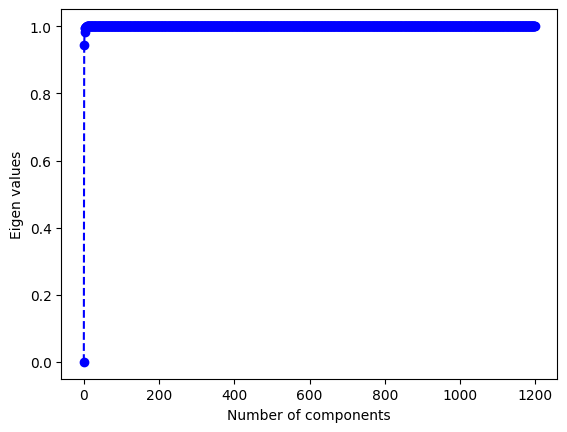

In [ ]:
# Best results were obtained for the gaussian similarity matrix with sigma=1
y_pred, kmeans = spectral_clusterer(
    X,
    metric="gaussian",
    sigma=2,
    n_clusters=2,
    plot_eigen=True
    )


In [ ]:
## Adding the clusters to the given data
data["cluster"] = pd.Series(y_pred)
data.head()


,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat,cluster
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329,1
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516,1
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215,1
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126,1
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330,1


<Axes: xlabel='cov1', ylabel='cov2'>

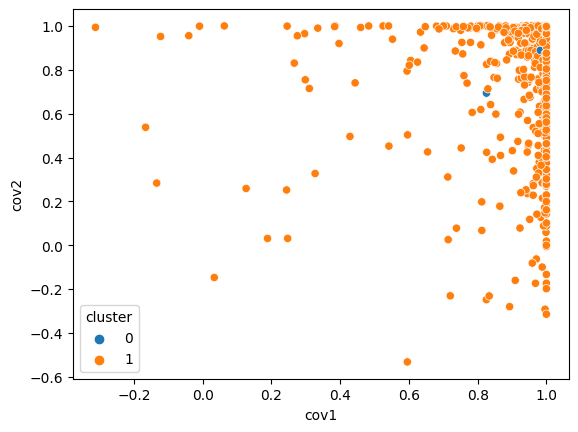

In [ ]:
# Example plot
sns.scatterplot(data, x="cov1", y="cov2", hue="cluster")


> Note that in this case, the outliers might not look like outliers since this is a 10 dimension dataset